In [1]:
import numpy as np, random,math
import pandas as pd
from google.colab import output
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500

## **The Problem**

**Travelling salesman problem.**

The problem is described as below:

*“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”*

Important rules:
1.   Each city needs to be visited exactly one time
2.   We must return to the starting city, so our total distance needs to be calculated accordingly

Genetic algorithm focuses on finding optimal solutions by implementing the theory of natural selection and evolution. In the travelling salesman problem, we will have to find the best possible route for the salesman to cover with least possible distance.

In order to obtain this, we will need to:\
  a)identify the route as per the rule of the problem a.k.a chromosome\
  b)calculate the distance which is the fitness and \
  c)identify all possible routes to acheive the optimum route which is the natural selection and evolution process that is iterative in nature.

Genetic Algorithms follows the below steps in formulating solution for any given problem.

1) Create initial population\
2) Determine the fitness\
3) Select parents\
4) Create children\
5) Mutate\
6) Repeat

In order to find the optimum solution, we need to find the best chromosome (route) with highest fitness (least distance).




## **The problem and the cost function**

**Step1: Create Initial populatiion**

In order to create our initial population, we need a gene and a unique chromosome. In our case a city is a gene and the route created by multiple cities is the chromosome. We then make sure that the routes do not repeat.

# **Creating the Gene (City)**

In [2]:
def create_cities(num_cities):
  dtypes=np.dtype(
      [
        ("CityID",int),
        ("CityName",str),
        ("Latitude",int),
        ("Longitude",int),
      ]
  )
  city_df=pd.DataFrame(np.empty(0,dtype=dtypes))

  for i in range(0,num_cities):
    city="City"+ str(i)
    x=int(random.random() * 200)
    y=int(random.random() * 200)
    df1=pd.DataFrame(data=[[str(i),city,x,y]],columns=["CityID","CityName","Latitude","Longitude"])
    city_df=pd.concat([city_df,df1],axis=0)

  city_df.index=range(len(city_df.index))
  
  return city_df

# **Creating cost or fitness function**

In [3]:
def calculate_distance(df_city,fromcity,tocity):
  distance=0
  
  x1=df_city['Latitude'].iat[fromcity]
  y1=df_city['Longitude'].iat[fromcity]

  x2=df_city['Latitude'].iat[tocity]
  y2=df_city['Longitude'].iat[tocity]
  
  xDis=abs(x1 - x2)
  yDis=abs(y1 - y2)

  distance=np.sqrt((xDis **2) + (yDis **2))

  return distance

## **Creating chromosome (Route)**

In [4]:
def create_route(city_list,cur_list,origin):
  #the route is the individual
  #city_list is the full list of cities
  #cur_list is the list of routes generated so for for this population. This is used to check if we are generating same route twice.
  #origin is the starting point of the journey and this the point where the route should also end.

  num_cities=len(city_list.index)
  
  final_route=[]
  selected_cities=[]
  temp_df=city_list['CityID'].tail(-1)
 

  if len(cur_list)==0:
    selected_cities=temp_df.tolist()
    np.random.shuffle(selected_cities)
    final_route.append(origin)
    final_route.extend(selected_cities)
    final_route.append(origin)

  else:
    for i in range(0,len(cur_list)):
      final_route=[]
      selected_cities=[]
      old_route=''.join(str(e) for e in cur_list[i])
      
      selected_cities=temp_df.tolist()

      np.random.shuffle(selected_cities)
      final_route.append(origin)
      final_route.extend(selected_cities)
      final_route.append(origin)

      new_route=''.join(str(e) for e in final_route)

      if old_route != new_route:
        break
  return final_route
  

  
  

# **Calcutaing the fitness of the chromosome**

In [5]:
def get_route_distance(route,cityList):
  #route distance is the cost of the individual
  distance=0
  
  for i in range(0,len(route)-1):
    origin=route[i]
    destination=route[i+1]
    distance +=calculate_distance(cityList,int(origin),int(destination))
    
  return distance    


# **Initial population**

In [6]:
def init_population(popSize,cityList):
  route_list=[] #List to store the routes created. This will be passed on to create_route function which creates a new route that is not in the route list
  
  dtypes=np.dtype(
      [
        ("RouteID",int),
        ("Route",str),
        ("Distance",float),
      ]
  )
  population_df=pd.DataFrame(np.empty(0,dtype=dtypes))
    
  for i in range(0,popSize):
    route=[]
    route=create_route(cityList,route_list,0)
    routeStr=''
    routeStr=','.join(map(str,route)) #convert list to string

    route_list.append(routeStr)
    distance=get_route_distance(route,cityList)
    
    df1=pd.DataFrame(data=[[str(i),routeStr,distance]],columns=["RouteID","Route","Distance"])
    
    population_df=pd.concat([population_df,df1],axis=0)

  population_df.index=range(len(population_df.index))

  return population_df  

# **Create Generations**


In [7]:
def createGenerations(currentGen, carry_fwd_rate, mutationRate,city_df):

  dtypes=np.dtype(
      [
        ("RouteID",int),
        ("Route",str),
        ("Distance",float),
      ]
  )
  nextGen=pd.DataFrame(np.empty(0,dtype=dtypes))

  rankedroutes=currentGen.sort_values(['Distance'],ascending=True)
  
  if len(rankedroutes.index)>0:
    parents=createParents(rankedroutes,carry_fwd_rate)
    children=createChildren(parents,carry_fwd_rate)
    gen=mutatePopulation(children,mutationRate)

    for i in range(0,len(gen)):
      route=[]
      routeStr=gen[i]
      route=list(routeStr.split(","))
      
      distance=get_route_distance(route,city_df)

      df1=pd.DataFrame(data=[[str(i),routeStr,distance]],columns=["RouteID","Route","Distance"])
      
      nextGen=pd.concat([nextGen,df1],axis=0)

    nextGen.index=range(len(nextGen.index))

  return nextGen  

 

In [8]:
def createParents(routes_ranked_df,retention_rate):
  total_routes=len(routes_ranked_df.index)
  retention_count=int(total_routes*retention_rate)
  parents=[]
  temp=[]
  retained=[]
  for i in range(0,retention_count):
    rtStr=routes_ranked_df['Route'].iloc[i]
    retained.append(rtStr)

  for i in range(retention_count,total_routes):
      rtStr=routes_ranked_df['Route'].iloc[i]
      temp.append(rtStr)

  parents = retained + temp

  np.random.shuffle(parents)

  return parents  

In [9]:
def createChildren(parent_lst,retention_rate):
  retention_cnt=int((len(parent_lst)+1)*retention_rate)
  
  childSize=len(parent_lst)-retention_cnt
  children=[]

  for i in range(0,retention_cnt):
    children.append(parent_lst[i])

  for i in range(0,childSize):
    parent1=parent_lst[i]
    parent2=parent_lst[len(parent_lst)-i-1]

    after_cross=crossover(parent1,parent2)

    children.append(after_cross)

  return children  


# **Crossover**

In [10]:
def crossover(parent1,parent2):
  child=[]
  c1=[]
  c2=[]

  p1=list(parent1.split(",")) 
  p2=list(parent2.split(","))

  p1=p1[1:-1]#remove the first and last item from the route as they our start and end points
  p2=p2[1:-1] #remove the first and last item from the route as they our start and end points

  start_pos=random.randint(1,len(p1))
  end_pos=random.randint(1,len(p1))

  for i in range(min(start_pos,end_pos),max(start_pos,end_pos)):
    c1.append(p1[i])

  c2=[item for item in p2 if item not in c1]

  child.append(parent1[0])
  child.extend(c1)
  child.extend(c2)
  child.append(parent1[0])
  childStr=','.join(map(str,child))

  return childStr

# **Mutation** 

In [11]:
def mutatePopulation(population, mutationRate):
    #this functions runs the mutation algorithm over the population
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [12]:
def mutate(individual, mutationRate):
    #this function mutates an individual which is route in our case
    
    ind1=individual.split(",")
    ind1=ind1[1:-1]
    no_of_swaps=math.ceil(len(ind1)*mutationRate) #determine the number of cities to be swapped
    swap_cnt=0
    mutated_ind=[]

    while swap_cnt <=no_of_swaps:
      swap_from,swap_to=choose_different_indices(len(ind1)) #choose the positions to swap
      swap_to_city=ind1[swap_to]                            #choose the city to be swaped
      swap_from_city=ind1[swap_from]                        #choose the city to swaped from
      ind1[swap_to]=swap_from_city
      ind1[swap_from]=swap_to_city

      swap_cnt=swap_cnt+1                                  #counter to identify the no of swap instances

    mutated_ind.append(0)
    mutated_ind.extend(ind1)
    mutated_ind.append(0)

    mutated=','.join(map(str,mutated_ind))
    return mutated

In [13]:
def choose_different_indices(max_value):
  index1 = np.random.randint(1,max_value)
  index2 = np.random.randint(1,max_value)
  if index1 == index2:
    return choose_different_indices(max_value)
  return index1, index2

# **Approach and justification**


> The First city in the list is considered to be the origination point. The route is constructed from the 2nd city for the number of cities and the fist city is added to both ends of the route to facilitate calculation of distance from origination then to other cities and back to origination.

> Distance between 2 cities is calcuated using pythogorean theorm assuming that they are on a 2D coordinate plane.

> City data is stored as Dataframes. This was to facilitate the usage of external dataset if required.

> Route and Best route in the generation are all stored in DataFrames to enable easy view of the dataset, facilitate debugging and support visualisation.







# **Genetic Algorithm**

In [14]:
def run_genetic(params):

  popSize=params.number_in_population 
  no_of_generations=params.number_of_generations 
  carry_fwd_rate=params.retention_rate 
  mutationRate=params.mutation_rate
  no_of_cities=params.no_of_cities
  
  gen_dtl=pd.DataFrame()

  city_df=create_cities(no_of_cities)
  city_df=city_df.convert_dtypes()
  print("Creating initial population...")
  pop=init_population(popSize,cityList=city_df)
  
  pop.sort_values(['Distance'],ascending=True)

  gen_route=pop['Route'].iloc[0]
  gen_distance=pop['Distance'].iloc[0]
  gen_cnt=0
  
  df1=pd.DataFrame(data=[[str(gen_cnt),gen_route,gen_distance]],columns=["GenID","Route","Distance"])
      
  gen_dtl=pd.concat([gen_dtl,df1],axis=0)
  
  display(gen_dtl)

  for i in range(0,no_of_generations):
    output.clear()
    print("Executing for Generation # ",i+1)
    pop=createGenerations(pop,carry_fwd_rate,mutationRate,city_df)
    pop.sort_values(['Distance'],ascending=True)
    gen_route=pop['Route'].iloc[0]
    gen_distance=pop['Distance'].iloc[0]
    gen_cnt=i+1
    df1=pd.DataFrame(data=[[str(gen_cnt),gen_route,gen_distance]],columns=["GenID","Route","Distance"])
    gen_dtl=pd.concat([gen_dtl,df1],axis=0)
    output.clear()
  
  return gen_dtl  

# **Output the results from the Genetic Algorithm**

In [15]:
def output_results(final_df,params):
  
  print(" Parameters :\n No of Cities:",params.no_of_cities,"\n Population Size:",params.number_in_population, \
        "\n Carry Forward Rate:",params.retention_rate,"\n Mutation Rate:",params.mutation_rate,"\n No of Generations:",params.number_of_generations,"\n")

  initDistance=final_df['Distance'].head(1).to_string(index=False)
  initRoute=final_df['Route'].head(1).to_string(index=False)

  finalDistance=final_df['Distance'].tail(1).to_string(index=False)
  finalRoute=final_df['Route'].tail(1).to_string(index=False)

  gen_df_sorted=final_df.sort_values(['Distance'],ascending=True)
  bestDistance=gen_df_sorted['Distance'].head(1).to_string(index=False)
  bestRoute=gen_df_sorted['Route'].head(1).to_string(index=False)
  bestRouteGenId=gen_df_sorted['GenID'].head(1).to_string(index=False)

  print("Initial Route : ",initRoute, " --> Distance Covered: ",initDistance)
  print("Final Route   : ",finalRoute, " --> Distance Covered: ",finalDistance)
  print("Best Route    : ",bestRoute, " --> Distance Covered: ",bestDistance)
  print("Best Route found in generation :",bestRouteGenId)


# **Function to plot the results**

In [16]:
def plotResults(final_df):
  
  plt_df=final_df[['GenID','Distance']]
  plt_df=plt_df.convert_dtypes()
  plt.plot(plt_df["GenID"], plt_df["Distance"])

  font1 = {'family':'serif','color':'blue','size':15}
  font2 = {'family':'serif','color':'darkred','size':12}

  plt.xlabel('Generation',fontdict=font2)
  plt.ylabel('Distance',fontdict=font2)
  plt.xscale('linear')
  plt.title('Distance travelled by salesman over generations\n',fontdict=font1)
  
  print("\n")
  
  plt.rcParams['figure.figsize'] = (20, 9)

  plt.show()

**Running the genetic algorithm**


> Set Parameters



In [17]:
class parameters:
  def __init__(self):
    self.number_in_population = 100
    self.number_of_generations = 500
    self.retention_rate = 0.2
    self.mutation_rate=0.3
    self.no_of_cities=10
    self.show_graph=True

> Run the genetic algorithm



 Parameters :
 No of Cities: 10 
 Population Size: 10 
 Carry Forward Rate: 0 
 Mutation Rate: 0 
 No of Generations: 50 

Initial Route :  0,4,9,5,1,6,7,3,8,2,0  --> Distance Covered:  990.602744
Final Route   :  0,8,7,6,9,2,3,4,1,5,0  --> Distance Covered:  1064.994659
Best Route    :  0,9,2,5,6,8,4,1,7,3,0  --> Distance Covered:  702.470794
Best Route found in generation : 11




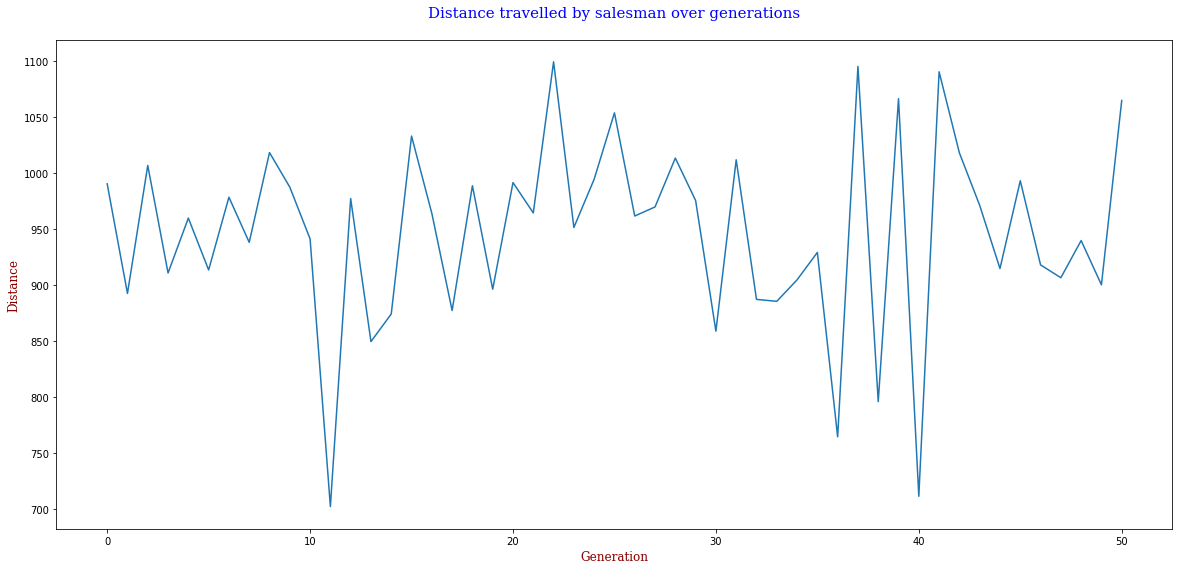

In [ ]:
params=parameters()

gen_df=run_genetic(params)

output_results(gen_df,params)

if params.show_graph==True:
  plotResults(gen_df)


**Iteration 2**

 Parameters :
 No of Cities: 10 
 Population Size: 100 
 Carry Forward Rate: 0 
 Mutation Rate: 0 
 No of Generations: 500 

Initial Route :  0,3,5,2,7,9,1,8,6,4,0  --> Distance Covered:  1323.548815
Final Route   :  0,4,8,6,9,1,5,7,3,2,0  --> Distance Covered:  1299.809652
Best Route    :  0,8,9,2,4,5,7,1,6,3,0  --> Distance Covered:  669.996309
Best Route found in generation : 458




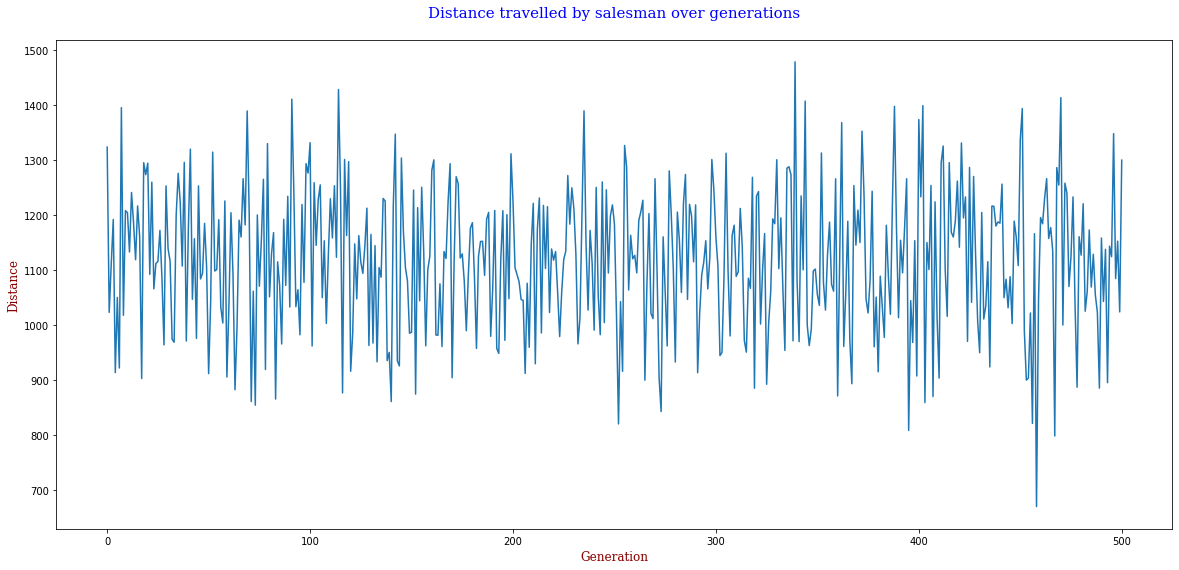

In [ ]:
params=parameters()

gen_df=run_genetic(params)

output_results(gen_df,params)

if params.show_graph==True:
  plotResults(gen_df)


**Iteration 3**

 Parameters :
 No of Cities: 10 
 Population Size: 100 
 Carry Forward Rate: 0.2 
 Mutation Rate: 0.3 
 No of Generations: 500 

Initial Route :  0,3,8,2,6,4,7,1,9,5,0  --> Distance Covered:  988.119161
Final Route   :  0,5,1,4,6,9,8,7,3,2,0  --> Distance Covered:  1067.539727
Best Route    :  0,9,5,4,1,8,6,7,3,2,0  --> Distance Covered:  736.035363
Best Route found in generation : 359




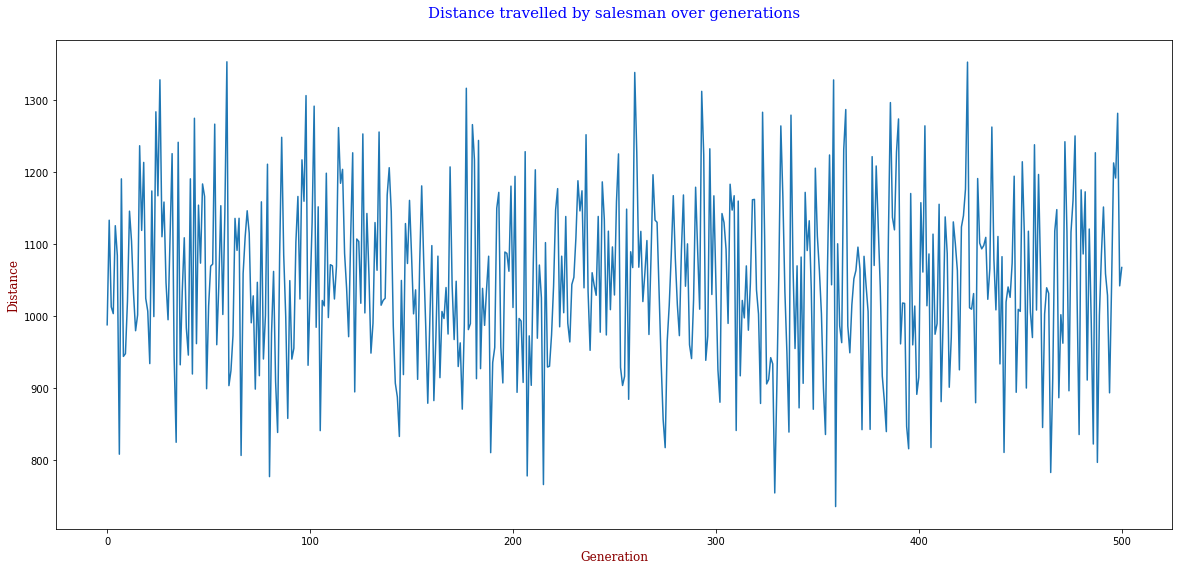

In [ ]:
params=parameters()

gen_df=run_genetic(params)

output_results(gen_df,params)

if params.show_graph==True:
  plotResults(gen_df)


# **Results and Conclusions**

In an ideal scenario, the execution of the Genetic Algorithm can be stopped if we have arrived at the expected value of the cost or fitness function. In our current scenario, as we will not be able to determine the the expected value before we start the solution, we continue our execution as per the parameters and run them till the last generation and then find the best route across generations.